<div class="alert alert-block alert-info">
<b>Deadline:</b> May 03, 2023 (Wednesday) 23:00
</div>

# Exercise 3. Variational autoencoders

The goal of this exercise is to get familiar with *variational* autoencoders. The model was presented by [Kigma and Welling, 2013](https://arxiv.org/pdf/1312.6114.pdf).

In [1]:
skip_training = True  # Set this flag to True before validation and submission

In [2]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

import tools, warnings
warnings.showwarning = tools.customwarn

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import tools
import tests

In [4]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is /coursedata


In [5]:
# Select the device for training (use GPU if you have one)
#device = torch.device('cuda:0')
device = torch.device('cpu')

In [6]:
# The models are always evaluated on CPU
if skip_training:
    device = torch.device("cpu")

# Data

In this exercise, we will use the same varianceMNIST dataset from notebook 2.

In [7]:
# We will use varianceMNIST data in this exercise
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Lambda(lambda x: x * torch.randn_like(x))
])

trainset = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

We visualize some random training samples in the cell below. As you can see, we can quite easily recognize the digits.

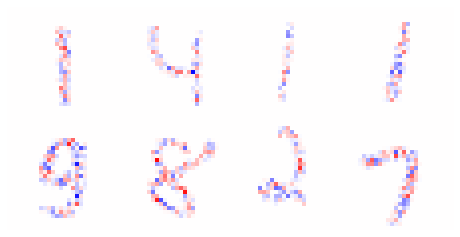

In [8]:
images, labels = next(iter(trainloader))
tools.show_images(images[:8], ncol=4, cmap=plt.cm.bwr, clim=[-3,3])

# Variational autoencoder (VAE)

In this exercise, we will assume the following generative model for the data:
* the latent codes are normally distributed:
$$
  p(z) = \mathcal{N}(z \mid 0, I)
$$
where $I$ is the identity matrix.
* the data are produced from the latent codes as follows:
$$
  p(x \mid z) =\mathcal{N}\left(x \mid \mu_x(z), \:\text{diag}(\sigma^2_x(z)) \right)
$$
where $\mu_x(z)$ and $\sigma^2_x(z)$ are some deterministic functions that we need to learn.

## Encoder

In the cell below, your task is to implement the encoder of a VAE.
The proposed architecture of the encoder is similar to the encoder from notebook 2:
* `Conv2d` layer with kernel size 5 with 6 output channels, followed by ReLU
* `Conv2d` layer with kernel size 5 with 16 output channels, followed by ReLU
* Fully-connected layer with 250 output features, followed by ReLU
* Two heads: each is a fully-connected layer with `n_components` elements.

The two heads are needed to produce two outputs of the encoder:
* means $\mu_z$ of the approximate distribution of the latent code $\bar z$
* log-variance $\tilde z$ of the approximate distribution of the latent code $z$.
To guarantee that the variance is positive, we parameterize it as $\sigma_z^2 = \exp(\tilde z)$.

Note: The exact architecture is not tested in this notebook.

In [9]:
class Encoder(nn.Module):
    def __init__(self, n_components):
        """
        Args:
          n_components (int): Number of elements in produced codes.
        """
        # YOUR CODE HERE
        self.n_components = n_components
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.lin1 = nn.Linear(16 * 20 * 20, 250)
        self.mean = nn.Linear(250, n_components)
        self.log_var = nn.Linear(250, n_components)
        
    def forward(self, x):
        """
        Args:
          x of shape (batch_size, n_channels=1, width, height): Examples to encode.

        Returns:
          z_mean of shape (batch_size, n_components): Means of the approximate distributions of the codes.
          z_logvar of shape (batch_size, n_components): Log-variances of the approximate distributions of the codes.
        """
        # YOUR CODE HERE
        batch_size = x.shape[0]
        y1 = F.relu(self.conv1(x))
        y2 = torch.flatten(F.relu(self.conv2(y1)), start_dim = 1, end_dim = 3)
        y3 = F.relu(self.lin1(y2))
        z_mean = self.mean(y3)
        z_logvar = self.log_var(y3)
        return z_mean, z_logvar

    def sample(self, z_mean, z_logvar):
        """Draw one sample from the posterior of the latent codes described by given parameters.
        This is needed for the re-parameterization trick.
        
        Args:
          z_mean of shape (batch_size, n_components): Means of the approximate distributions of the codes.
          z_logvar of shape (batch_size, n_components): Log-variance of the approximate distributions of the codes.
        
        Returns:
          z of shape (batch_size, n_components): Drawn samples.
        """
        # YOUR CODE HERE
        eps = torch.normal(mean = torch.zeros(self.n_components), std = torch.ones(self.n_components))
        z = z_mean + eps * torch.sqrt(torch.exp(z_logvar))
        return z

In [10]:
def test_Encoder_shapes():
    n_components = 10 # dimensional latent space
    encoder = Encoder(n_components=n_components)

    x = torch.randn(3, 1, 28, 28)
    mu, logsigma = encoder(x)
    assert mu.shape == torch.Size([3, n_components]), f"Bad mu.shape: {mu.shape}"
    assert logsigma.shape == torch.Size([3, n_components]), f"Bad logsigma.shape: {logsigma.shape}"
    print('Success')

test_Encoder_shapes()

Success


In [11]:
def test_Encoder_sample():
    n_components = 10 # dimensional latent space
    encoder = Encoder(n_components=n_components)

    z_mean = torch.zeros(3, n_components)
    z_logvar = torch.log(2*torch.ones(3, n_components))
    z = encoder.sample(z_mean, z_logvar)
    assert z.shape == z_mean.shape, f"Bad z.shape: {z.shape}"
    print('Success')

test_Encoder_sample()

Success


### Kullback-Leibler divergence loss

One term of the loss function minimized during training of a VAE is the Kullback-Leibler divergence between the approximate distribution of the latent codes $q(z) = \mathcal{N}(z \mid \mu_z, \sigma^2_z)$ and the prior distribution $p(z) = \mathcal{N}(z \mid 0, I)$:
$$
\frac{1}{N} \sum_{i=1}^N \int q(z_i) \log \frac{q(z_i)}{p(z_i)} dz_i
$$
where $N$ is the number of samples (batch size in our implementation).

We will implement this loss function in the cell below.

Note: Please do **not** use functions from `torch.distributions` module. 

In [12]:
def loss_kl(z_mean, z_logvar):
    """
    Args:
      z_mean of shape (batch_size, n_components): Means of the approximate distributions of the codes.
      z_logvar of shape (batch_size, n_components): Log-variance of the approximate distributions of the codes.
    
    Returns:
      loss (torch scalar): Kullback-Leibler divergence.
    """
    # YOUR CODE HERE
    batch_size = z_mean.shape[0]
    loss = torch.sum((z_mean**2 / 2) + (1/2) * (torch.exp(z_logvar) - 1 - z_logvar)) / batch_size
    return loss

In [13]:
def test_loss_kl():
    n_components = 3
    z_mean = torch.zeros(3, n_components)
    z_logvar = torch.log(2*torch.ones(3, n_components))
    loss = loss_kl(z_mean, z_logvar)
    expected = torch.tensor(0.4602792263031006)
    print('loss:', loss.item())
    print('expected:', expected.item())
    assert torch.allclose(loss, expected, atol=1e-5), "loss does not match expected value."
    print('Success')

test_loss_kl()

loss: 0.4602792263031006
expected: 0.4602792263031006
Success


## Decoder

The decoder computes the predictive distribution of the data given latent code $z$ according to our
assumed generative model:
$$
  p(x \mid z) = \mathcal{N}\left(x \mid \mu_x(z), \sigma^2_x(z) \right)
$$
where $\mu_x(z)$ and $\sigma^2_x(z)$ are some deterministic functions that we need to learn.

The proposed architecture of the decoder is similar to the one from notebook 2:
* Fully-connected layer with 250 output features, followed by ReLU
* Fully-connected layer with 250 input features, followed by ReLU
* `ConvTranspose2d` layer with kernel size 5 with 16 input channels, followed by ReLU
* Two heads made of `ConvTranspose2d` layer with kernel size 5 with 6 input channels.

The two heads are needed to produce two outputs of the decoder:
* means $\mu_x$ of the predictive distribution of the data
* log-variance $\tilde x$ of the predictive distribution of the data.
To guarantee that the variance is positive, we parameterize it as $\sigma_x^2 = \exp(\tilde x)$.

**Important:**

In practice, learning the proposed generative model is difficult for the varianceMNIST dataset. The problem is that the background pixels have zero variances, which corresponds to infinitely low loss values. Thus, training may concentrate entirely on modeling the variance of the background pixels. To prevent this, we define the minimum allowed value of the predictive variance $\tilde x$ and save it in the model as
```
    self.register_buffer('min_logvar', -6 * torch.ones(1))
```
We need to use `register_buffer` to make sure that the variable is on the same device as the trained parameters of the model. We can use this code in the forward function to limit the predicted variance by `self.min_logvar`:
```
logvar = self.min_logvar + F.softplus(logvar - self.min_logvar)
```

In [14]:
class Decoder(nn.Module):
    def __init__(self, n_components):
        """
        Args:
          n_components (int): Number of elements in input codes.
        """
        # YOUR CODE HERE
        super(Decoder, self).__init__()
        self.lin3 = nn.Linear(n_components, 250)
        self.lin4 = nn.Linear(250, 16 * 20 * 20)
        self.conv_transpose1 = nn.ConvTranspose2d(16,6,kernel_size=5)
        self.conv_transpose_mean = nn.ConvTranspose2d(6,1,kernel_size=5)
        self.conv_transpose_log_var = nn.ConvTranspose2d(6,1,kernel_size=5)
        self.register_buffer('min_logvar', -6 * torch.ones(1))

    def forward(self, z):
        """
        Args:
          z of shape (batch_size, n_components): Input codes.

        Returns:
          y_mean of shape (batch_size, n_channels=1, width, height): Means of the probability distributions
              describing the data examples that correspond to the given codes.
          y_logvar of shape (batch_size, n_channels=1, width, height): Log-variances of the probability
              distributions describing the data examples that correspond to the given codes.
        """
        # YOUR CODE HERE
        batch_size = z.shape[0]
        y5 = F.relu(self.lin3(z))
        y6 = torch.reshape(F.relu(self.lin4(y5)), (batch_size, 16, 20, 20))
        y7 = F.relu(self.conv_transpose1(y6))
        y_mean = self.conv_transpose_mean(y7)
        y_logvar = self.conv_transpose_log_var(y7)
        y_logvar = self.min_logvar + F.softplus(y_logvar - self.min_logvar)
        return y_mean, y_logvar

In [15]:
def test_Decoder_shapes():
    n_components = 10 # dimensional latent space
    decoder = Decoder(n_components=n_components)

    z = torch.randn(3, n_components)
    y_mean, y_logvar = decoder(z)
    y_shape = torch.Size([3, 1, 28, 28])
    assert y_mean.shape == y_shape, "Bad shape of y_mean: y_mean.shape={}".format(y_mean.shape)
    assert y_logvar.shape == y_shape, "Bad shape of y_logvar: y_logvar.shape={}".format(y_logvar.shape)
    print('Success')

test_Decoder_shapes()

Success


### Expected log-likelihood term

The second term of the VAE loss function is minus log-likelihood estimated using sample $z_i$ from the approximate distribution $q(z_i)$ of the latent code that corresponds to training example $x_i$.

$$
- \int q(z_i) \log \mathcal{N}\left(x_i \mid \mu_x(z_i), \:\text{diag}(\sigma^2_x(z_i))\right) dz_i
$$
where $\mathcal{N}(x_i)$ is a multivariate normal distribution over all pixel values of image $x_i$.

Your task is to implement that function **without** constant terms
$$
\frac{28 \cdot 28}{2} \log 2 \pi
$$
that do not depend on $\mu_x(z_i)$ or $\sigma_x(z_i)$.

Note that $\mathcal{N}\left(x_i \mid \mu_x(z_i), \:\text{diag}(\sigma^2_x(z_i))\right)$ is a multivariate normal distribution with a **diagonal** covariance matrix. The fact that the covariance matrix is diagonal simplifies the computations a lot.

In [16]:
def loss_loglik(y_mean, y_logvar, x):
    """
    Args:
      y_mean of shape (batch_size, 1, 28, 28): Predictive mean of the VAE reconstruction of x.
      y_logvar of shape (batch_size, 1, 28, 28): Predictive log-variance of the VAE reconstruction of x.
      x of shape (batch_size, 1, 28, 28): Training samples.
    
    Returns:
      loss (torch scalar): Expected log-likelihood loss.
    """
    # YOUR CODE HERE
    batch_size = x.shape[0]
    loss = (1/2) * (torch.sum(y_logvar) + torch.sum((x - y_mean)**2 / torch.exp(y_logvar))) / batch_size
    return loss


In [17]:
def test_loss_loglik():
    y_mean = torch.ones(3, 1, 28, 28) 
    y_logvar = torch.log(2*torch.ones(3, 1, 28, 28))
    y_logvar[:,:,:14,:] = torch.log(torch.ones(1, 1, 14, 28))

    x = torch.zeros(3, 1, 28, 28)
    x[:,:,:14,:] = torch.ones(3, 1, 14, 28)

    loss = loss_loglik(y_mean, y_logvar, x)
    expected = torch.tensor(233.8568572998047)
    
    print('loss:', loss)
    print('expected:', expected)
    assert torch.allclose(loss, expected), "loss does not match expected value."
    print('Success')

test_loss_loglik()

loss: tensor(233.8569)
expected: tensor(233.8569)
Success


# Train a variational autoencoder

In [18]:
# Create a variational autoencoder
n_components = 10 # dimensional latent space
encoder = Encoder(n_components=n_components)
decoder = Decoder(n_components=n_components)

encoder = encoder.to(device)
decoder = decoder.to(device)

### Training loop

Implement the training loop in the cell below. One iteration of the training loop process one mini-batch of data in the following way:
* The encoder is used to compute approximate distributions $q(z)$ of the latent codes corresponding to the training samples.
* One sample $z_i$ is drawn from each approximate posterior $q(z)$ (use function `Encoder.sample()` for that).
* The decoder uses samples $z_i$ to compute the predictive distribution for the training examples.
* The minimized loss is the sum of the KL-divergence loss `loss_kl()` and the expected log-likelihood loss `loss_loglik()` defined earlier.

Implement the training loop in the cell below. The recommended hyperparameters:
* Adam optimizer with learning rate 0.001
* Number of epochs: 10

Hints:
- The loss at convergence should be close to -1760.

In [19]:
# Training loop
if not skip_training:
    # YOUR CODE HERE
    n_epochs = 10
    optimizer_endcoder = torch.optim.Adam(encoder.parameters(), lr=0.001)
    optimizer_decoder = torch.optim.Adam(decoder.parameters(), lr=0.001)
    for i in range(n_epochs):
        print("epoch {}: ".format(i))
        for images, labels in trainloader:
            optimizer_endcoder.zero_grad()
            optimizer_decoder.zero_grad()
            z_mean, z_logvar = encoder.forward(images)
            z = encoder.sample(z_mean, z_logvar)
            y_mean, y_logvar = decoder.forward(z)
            loss = loss_kl(z_mean, z_logvar) + loss_loglik(y_mean, y_logvar, images)
            loss.backward()
            optimizer_endcoder.step()
            optimizer_decoder.step()
        print(loss)
        

epoch 0: 
tensor(-1638.5282, grad_fn=<AddBackward0>)
epoch 1: 
tensor(-1711.5499, grad_fn=<AddBackward0>)
epoch 2: 
tensor(-1695.5343, grad_fn=<AddBackward0>)
epoch 3: 
tensor(-1759.7322, grad_fn=<AddBackward0>)
epoch 4: 
tensor(-1708.7196, grad_fn=<AddBackward0>)
epoch 5: 
tensor(-1755.7280, grad_fn=<AddBackward0>)
epoch 6: 
tensor(-1772.4136, grad_fn=<AddBackward0>)
epoch 7: 
tensor(-1726.3925, grad_fn=<AddBackward0>)
epoch 8: 
tensor(-1770.3719, grad_fn=<AddBackward0>)
epoch 9: 
tensor(-1687.0522, grad_fn=<AddBackward0>)


In [20]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
# Set confirm=False if you do not want to be asked for confirmation before saving.
if not skip_training:
    tools.save_model(encoder, '3_vae_encoder.pth', confirm=True)
    tools.save_model(decoder, '3_vae_decoder.pth', confirm=True)

Do you want to save the model (type yes to confirm)? yes
Model saved to 3_vae_encoder.pth.
Do you want to save the model (type yes to confirm)? yes
Model saved to 3_vae_decoder.pth.


In [21]:
if skip_training:
    encoder = Encoder(n_components=10)
    tools.load_model(encoder, '3_vae_encoder.pth', device)

    decoder = Decoder(n_components=10)
    tools.load_model(decoder, '3_vae_decoder.pth', device)

### Visualize embeddings

Let us visualize the latent space in the cell below. If your VAE does a good job, you should clearly see ten clusters corresponding to the ten classes.

Use t-SNE
/opt/software/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/software/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


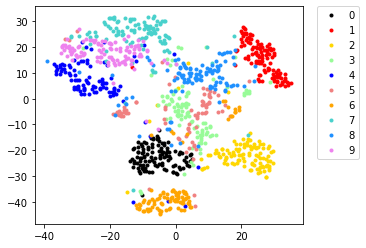

In [22]:
if encoder(torch.randn(3, 1, 28, 28).to(device))[0].shape == torch.Size([3, 10]):
    tests.visualize_embeddings(lambda x: encoder(x)[0], trainloader, n_samples=1000, device=device)

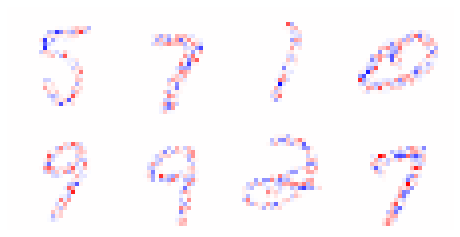

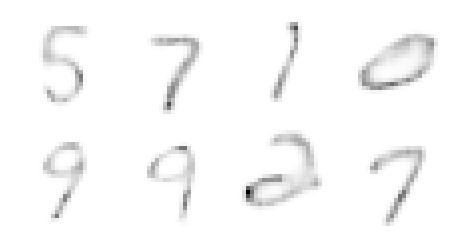

In [23]:
# In this cell, we visualize predictive variances of the model for each pixel.
# For a well-trained VAE, the variances should capture the shapes of the digits.
with torch.no_grad():
    dataiter = iter(trainloader)
    images, _ = next(dataiter)
    z_mean, z_logvar = encoder(images.to(device))
    y_mean, y_logvar = decoder(z_mean)

    # Visualize some data samples
    tools.show_images(images[:8], ncol=4, cmap=plt.cm.bwr, clim=[-3,3])
    # Visualize corresponding predictive variance in the pixel space
    tools.show_images(torch.exp(y_logvar[:8]), ncol=4, cmap='binary')

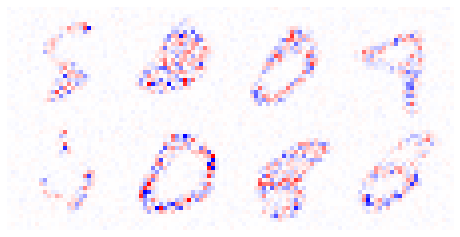

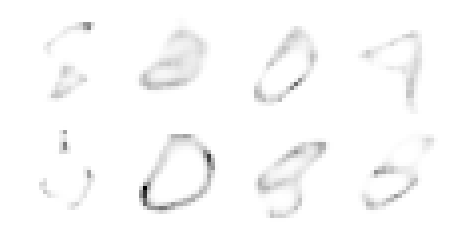

In [24]:
# Generate samples from VAE
# Note that samples may not be of great quality.
with torch.no_grad():
    z = torch.randn((8, 10)).to(device)
    x_mean, x_logvar = decoder(z)
    x = x_mean + torch.exp(0.5 * x_logvar) * torch.randn_like(x_logvar)
    tools.show_images(x[:8], ncol=4, cmap=plt.cm.bwr, clim=[-3,3])
    tools.show_images(torch.exp(x_logvar[:8]), ncol=4, cmap='binary')

# Test the quality of the produced embeddings by classification

We will test the quality of the produced encodings by training a classifier using the encoded images.

In [25]:
testset = torchvision.datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

In [26]:
# Encode data samples using the VAE encoder
@torch.no_grad()
def encode(dataset, encoder):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=False)
    embeddings = []
    labels = []
    for images, labels_ in dataloader:
        mu, logsigma = encoder(images.to(device))
        embeddings.append(mu)
        labels.append(labels_)

    embeddings = torch.cat(embeddings, dim=0)
    labels = torch.cat(labels, dim=0)
    return embeddings, labels

In [27]:
# Save and submit the VAE embeddings
if not skip_training:
    traincodes, trainlabels = encode(trainset, encoder)  # traincodes is (60000, 10)
    testcodes, testlabels = encode(testset, encoder)  # testcodes is (10000, 10)
    torch.save([traincodes, trainlabels, testcodes, testlabels], '3_vae_embeddings.pth')
else:
    traincodes, trainlabels, testcodes, testlabels = torch.load('3_vae_embeddings.pth', map_location=lambda storage, loc: storage)

In [28]:
# Train a simple linear classifier
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial', max_iter=400)
logreg.fit(traincodes.cpu(), trainlabels.cpu())

predicted_labels = logreg.predict(testcodes.cpu())  # (10000,)

# Compute accuracy of the linear classifier
accuracy = np.sum(testlabels.cpu().numpy() == predicted_labels) / predicted_labels.size
print('Accuracy with a linear classifier: %.2f%%' % (accuracy*100))
assert accuracy > .8, "Poor accuracy of the embeddings: classification accuracy is %.2f%%" % (accuracy*100)
print('Success')

Accuracy with a linear classifier: 88.12%
Success


<div class="alert alert-block alert-info">
<b>Conclusion</b>
</div>

In this exercise, we trained a variational autoencoder on a dataset in which useful information is in the variance of the pixel values and not the pixel values themselves. The code produced by the encoder of the VAE is only $10$-dimensional compared to the original $28 \times 28 = 784$-dimensional data. Still, the codes capture well the shapes of the digits.